# Pitchfork reviews analysis from Jan 5, 1999 to Jan 8, 2017
## Agenda:
* Who were the 10 most active authors?
* How many reviews has left each author's type? 
* How many reviews were left for each genre?
* Which genre was the most popular in each year?
* Who are top 10 artists with the biggest amount of reviews?
* How many times there was score 10 during those years?
* Top 10 highest score with artist, label as well as their average score.
* Is 'Best new music' status some how correlated with amount of reviews?

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Connecting to database, exporing tables

In [2]:
con = sqlite3.connect('database.sqlite')

In [3]:
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", con)
tables

,type,name,tbl_name,rootpage,sql
0,table,reviews,reviews,2,"CREATE TABLE reviews (\n\treviewid INTEGER,\n\..."
1,table,artists,artists,3,"CREATE TABLE artists (\n\treviewid INTEGER, ar..."
2,table,genres,genres,4,"CREATE TABLE genres (\n\treviewid INTEGER, gen..."
3,table,labels,labels,5,"CREATE TABLE labels (\n\treviewid INTEGER, lab..."
4,table,years,years,6,"CREATE TABLE years (\n\treviewid INTEGER, year..."
5,table,content,content,7,"CREATE TABLE content (\n\treviewid INTEGER, co..."


In [4]:
reviews = pd.read_sql("""SELECT *
                        FROM reviews;""", con)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18393 entries, 0 to 18392
Data columns (total 13 columns):
reviewid          18393 non-null int64
title             18393 non-null object
artist            18393 non-null object
url               18393 non-null object
score             18393 non-null float64
best_new_music    18393 non-null int64
author            18393 non-null object
author_type       14487 non-null object
pub_date          18393 non-null object
pub_weekday       18393 non-null int64
pub_day           18393 non-null int64
pub_month         18393 non-null int64
pub_year          18393 non-null int64
dtypes: float64(1), int64(6), object(6)
memory usage: 1.8+ MB


* TABLES years and artists are already included in reviews TABLE. So i will be working with 3 TABLES : reviews, labels, genres

In [5]:
genres = pd.read_sql("""SELECT *
                        FROM genres;""", con)
genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22680 entries, 0 to 22679
Data columns (total 2 columns):
reviewid    22680 non-null int64
genre       20313 non-null object
dtypes: int64(1), object(1)
memory usage: 354.5+ KB


In [6]:
labels = pd.read_sql("""SELECT *
                        FROM labels;""", con)
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20190 entries, 0 to 20189
Data columns (total 2 columns):
reviewid    20190 non-null int64
label       20152 non-null object
dtypes: int64(1), object(1)
memory usage: 315.5+ KB


### Who were the 10 most active authors?

In [7]:
def sql_query(query,database):
    return pd.read_sql_query(query,database)

In [8]:
query = '''
    SELECT 
        author,
        author_type,    
        COUNT(*) as amount_of_reviews 
    FROM reviews
    GROUP BY author
    ORDER BY COUNT(*) DESC
    LIMIT 10
'''
sql_query(query,con)

,author,author_type,amount_of_reviews
0,joe tangari,contributor,816
1,stephen m. deusner,contributor,725
2,ian cohen,contributor,699
3,brian howe,contributor,500
4,mark richardson,executive editor,476
5,stuart berman,contributor,445
6,marc hogan,senior staff writer,439
7,nate patrin,contributor,347
8,marc masters,contributor,312
9,jayson greene,senior editor,299


### How many reviews has left each author's type?

In [9]:
query = '''
    SELECT 
        author_type,
        COUNT(*) AS amount_of_reviews
    FROM reviews
    GROUP BY author_type
    ORDER BY COUNT(*) DESC
'''
sql_query(query,con)

,author_type,amount_of_reviews
0,contributor,12422
1,None,3906
2,senior editor,486
3,executive editor,475
4,senior staff writer,439
5,contributing editor,210
6,associate staff writer,105
7,deputy news editor,100
8,editor-in-chief,85
9,tracks coordinator,52


* Ok, contributor was the most active

### How many reviews were left for each genre?

In [10]:
query = '''
    SELECT 
        genre,
        COUNT(*) AS amount_of_reviews
    FROM genres
    GROUP BY genre
    ORDER BY COUNT(*) DESC
'''
sql_query(query,con)

,genre,amount_of_rewies
0,rock,9436
1,electronic,3874
2,None,2367
3,experimental,1815
4,rap,1559
5,pop/r&b,1432
6,metal,860
7,folk/country,685
8,jazz,435
9,global,217


###  The most discussed genre was rock . Maybe there is a difference in genres between years? 

* I've excluded 2017 year because database includes information only till Jan 8, 2017

In [11]:
query = '''
      SELECT 
         r.pub_year AS year,
         
         (SELECT 
                genre 
          FROM reviews
          JOIN genres USING (reviewid)
          WHERE pub_year = r.pub_year
          GROUP BY genre
          ORDER BY COUNT(*) DESC
          LIMIT 1) AS genre,
          
          (SELECT 
                COUNT(*) 
          FROM reviews
          JOIN genres USING (reviewid)
          WHERE pub_year = r.pub_year
          GROUP BY genre
          ORDER BY COUNT(*) DESC
          LIMIT 1) AS amount_of_reviews
          
      FROM reviews r
      JOIN genres USING(reviewid)
      GROUP BY r.pub_year
      HAVING r.pub_year != 2017
'''
sql_query(query,con)

,year,genre,amount_of_reviews
0,1999,rock,140
1,2000,rock,227
2,2001,rock,282
3,2002,rock,491
4,2003,rock,601
5,2004,rock,632
6,2005,rock,696
7,2006,rock,705
8,2007,rock,714
9,2008,rock,705


* No there isn't

### Who are the top 10 artists with the biggest amount of reviews?

In [12]:
query = '''
    SELECT artist,
           COUNT(*) as count 
    FROM reviews
    GROUP BY artist
    ORDER BY COUNT(*) DESC
    LIMIT 10
    
'''
sql_query(query,con)

,artist,count
0,various artists,688
1,guided by voices,23
2,david bowie,21
3,the beatles,21
4,mogwai,20
5,of montreal,20
6,neil young,19
7,robert pollard,19
8,the fall,18
9,animal collective,17


### How many times there was score 10 during those years?

In [13]:
query = '''
    SELECT 
        '1999-2017' AS years,
        COUNT(*) AS amount_of_score_10
    FROM reviews
    WHERE score = 10.0
'''
sql_query(query,con)

,years,amount_of_score_10
0,1999-2017,76


### Now let's look at 10 first highest scored titles as well as at average score for their artists and labels

In [14]:
query = '''
  SELECT 
        title,
        artist,
        label,
        score,
        
        (SELECT AVG(score)
         FROM reviews
         WHERE artist = r.artist
         GROUP BY artist)
         AS average_score_artist,
        
        (SELECT AVG(score)
         FROM reviews
         JOIN labels USING(reviewid)
         WHERE label = l.label
         GROUP BY label)
         AS average_score_label
        
  FROM reviews r
  JOIN labels l USING(reviewid)
  ORDER BY SCORE DESC
  LIMIT 10
'''
sql_query(query,con)

,title,artist,label,score,average_score_artist,average_score_label
0,metal box,public image ltd,universal,10.0,8.025000,6.807527
1,blood on the tracks,bob dylan,columbia,10.0,7.518750,6.985507
2,another green world,brian eno,island,10.0,7.944444,6.389024
3,songs in the key of life,stevie wonder,motown,10.0,10.000000,7.883333
4,in concert,nina simone,philips,10.0,7.566667,8.916667
5,tonight's the night,neil young,reprise,10.0,7.168421,6.851111
6,hounds of love,kate bush,emi,10.0,8.140000,7.482222
7,"sign ""o"" the times",prince,paisley park,10.0,7.184615,9.050000
8,1999,prince,warner bros.,10.0,7.184615,6.602976
9,purple rain,"prince, the revolution",warner bros.,10.0,9.300000,6.602976


### Is 'Best new music' status some how correlated with amount of reviews?

* I've took years between 2003-2016 because 'Best new music' status launched only in 2003 
(https://pitchfork.com/best/)

In [15]:
query = '''
    SELECT 
        pub_year AS year,
        COUNT(*) AS amount_of_reviews,
        SUM(best_new_music) AS bnm_status
    FROM reviews
    WHERE pub_year > 2002 AND pub_year < 2017
    GROUP BY pub_year
'''
data = sql_query(query,con)
data

,year,amount_of_reviews,bnm_status
0,2003,1060,47
1,2004,1121,43
2,2005,1186,39
3,2006,1189,31
4,2007,1216,43
5,2008,1201,36
6,2009,1171,89
7,2010,1170,87
8,2011,1165,82
9,2012,1185,90


* I've plotted the result data for more clarity. And added one more plot to check if there is a correlation between years and amount of 'Best new music' statuses

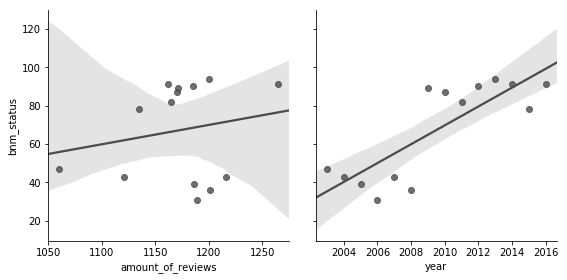

In [16]:
g = sns.PairGrid(data, y_vars=["bnm_status"], x_vars=["amount_of_reviews", "year"], height=4)
g.map(sns.regplot, color=".3")
plt.show()

* In first case there is a very weak correlation. In second case correlation is between weak and medium. So the amount of BNM statuses increases over the years.